In [1]:
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import autogluon 
from IPython.display import display

/home/antas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
# print(torch.cuda.current_device())
# print(torch.cuda.get_device_name(torch.cuda.current_device()))
device = torch.device('cpu') # bruh 

False
0


In [34]:
df = pd.read_csv('results/results_100_100000_new.csv', header=None)
model_num = 1
# display(df)
results = df.to_numpy()
print(results.shape)
print(results[:,-1].shape)
X = torch.tensor(results[:,:-1]).to(torch.float32).to(device)
if model_num == 1:
    X = torch.reshape(X,(X.shape[0],1,10,10))
y = torch.tensor(np.expand_dims(results[:,-1], axis=1)).to(torch.float32).to(device)
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, y_train.shape)
# Setting up Dataloader
# training_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(training_dataset, batch_size=24, shuffle=True)

(107898, 101)
(107898,)
torch.Size([107898, 1, 10, 10]) torch.Size([107898, 1])
torch.Size([72291, 1, 10, 10]) torch.Size([72291, 1])


In [58]:
input_size = X.shape[1]
if model_num == 0:
    model = nn.Sequential(nn.Linear(input_size, 64),
                        nn.ReLU(),
                        nn.Linear(64,32),
                        nn.ReLU(),
                        nn.Linear(32,32),
                        nn.BatchNorm2d(),
                        nn.ReLU(),
                        nn.Linear(32, 1),
                        nn.Sigmoid())
else:
    model = nn.Sequential(nn.Conv2d(1,64,2),
                          nn.ReLU(),
                          nn.BatchNorm2d(num_features=64),
                          nn.Conv2d(64,32,3),
                          nn.ReLU(),
                          nn.BatchNorm2d(num_features=32),
                          nn.Flatten(),
                          nn.Linear(1568, 30),
                          nn.ReLU(),
                          nn.Linear(30, 15),
                          nn.ReLU(),
                          nn.Linear(15,1),
                          nn.Sigmoid())
model.to(device)
print(model)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1568, out_features=30, bias=True)
  (8): ReLU()
  (9): Linear(in_features=30, out_features=15, bias=True)
  (10): ReLU()
  (11): Linear(in_features=15, out_features=1, bias=True)
  (12): Sigmoid()
)


In [59]:
loss_function = nn.MSELoss()
# loss_function = nn.BCELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)
losses = []

In [60]:
epochs = 1000
for epoch in range(epochs):
  y_pred = model(X_train)
  loss = loss_function(y_pred, y_train)
  losses.append(loss.item())

  model.zero_grad()
  loss.backward()

  optimizer.step()

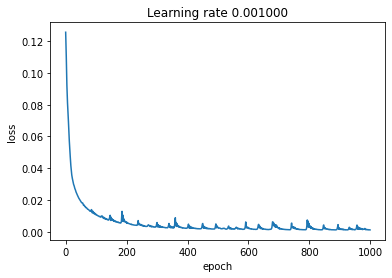

In [61]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [62]:
y_pred = model(X_test)
loss = loss_function(y_pred, y_test)
print(loss.item())
compiled_results = y_test.cpu().detach().numpy()
compiled_results = np.append(compiled_results, y_pred.cpu().detach().numpy(), axis=1)
results = pd.DataFrame(compiled_results, columns = ['y_test','y_pred'])
pd.set_option('display.max_rows', 30)
display(results)

0.017766855657100677


,y_test,y_pred
0,0.17,0.110856
1,0.93,0.709152
2,0.88,0.656199
3,0.60,0.360878
4,0.01,0.039649
...,...,...
3295,0.01,0.073872
3296,0.26,0.182848
3297,0.91,0.964233
3298,0.46,0.446859


In [35]:
# from autogluon docs
from autogluon.tabular import TabularPredictor, TabularDataset
X_train_flat = X_train.flatten(start_dim=1)

train_data = pd.DataFrame(X_train_flat).astype('float')
train_data['result'] = y_train

X_test_flat = X_test.flatten(start_dim = 1)
test_data = pd.DataFrame(X_test_flat).astype('float')
test_data['result'] = y_test




# need to convert to pandas dataframe and train
# get label
label = 'result'

predictor = TabularPredictor(label=label, problem_type='regression').fit(train_data)


y_pred_auto = predictor.predict(test_data.drop(columns=[label]))
y_pred_auto.head()

predictor.evaluate(test_data, silent=True)

No path specified. Models will be saved in: "AutogluonModels/ag-20230509_072347/"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20230509_072347/"
AutoGluon Version:  0.7.0
Python Version:     3.10.6
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #42~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Tue Apr 18 17:40:00 UTC 2
Train Data Rows:    72291
Train Data Columns: 100
Label Column: result
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1541.42 MB
	Train Data (Original)  Memory Usage: 57.83 MB (3.8% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify spec

[1000]	valid_set's rmse: 0.175849
[2000]	valid_set's rmse: 0.169656
[3000]	valid_set's rmse: 0.168033
[4000]	valid_set's rmse: 0.167565
[5000]	valid_set's rmse: 0.167251
[6000]	valid_set's rmse: 0.167295
[7000]	valid_set's rmse: 0.167367


	-0.1672	 = Validation score   (-root_mean_squared_error)
	10.77s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.145766
[2000]	valid_set's rmse: 0.13947
[3000]	valid_set's rmse: 0.137906
[4000]	valid_set's rmse: 0.137552
[5000]	valid_set's rmse: 0.137413
[6000]	valid_set's rmse: 0.137315
[7000]	valid_set's rmse: 0.137268
[8000]	valid_set's rmse: 0.137125
[9000]	valid_set's rmse: 0.137107
[10000]	valid_set's rmse: 0.137082


	-0.137	 = Validation score   (-root_mean_squared_error)
	13.73s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.2792	 = Validation score   (-root_mean_squared_error)
	37.24s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: CatBoost ...


KeyboardInterrupt: 